In [87]:
import cPickle
import datetime
import glob
import gzip
import os
import random
import shutil
import subprocess
import time
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

import ciepy as cpy
import projectpy as ppy

%matplotlib inline
%load_ext rpy2.ipython

random.seed(20150605)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
outdir = os.path.join(cpy.root, 'output',
                      'run_eqtl_analysis')
ppy.makedir(outdir)

private_outdir = os.path.join(cpy.root, 'private_output',
                              'run_eqtl_analysis')
ppy.makedir(private_outdir)

In [4]:
gene_info = pd.read_table('/raid3/projects/CARDIPS/data/public/gencode_v19/gene_info.tsv',
                          index_col=0)

fn = os.path.join(cpy.root, 'output', 'eqtl_input', 'gene_to_regions.p')
gene_to_regions = cPickle.load(open(fn, 'rb'))

vsd = pd.read_table(os.path.join(cpy.root, 'output', 'eqtl_input', 'vst_counts.tsv'), index_col=0)

# Normality of Expression Values

I want to see how normal the expression values are.

In [5]:
res = stats.mstats.normaltest(vsd, axis=1)

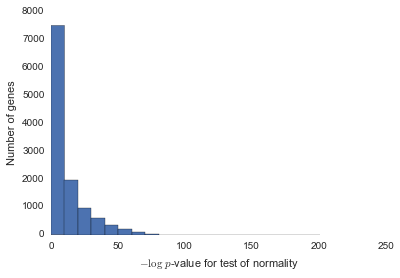

In [6]:
pd.Series(-1 * np.log(res[1])).hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$-\log$ $p$-value for test of normality');

In [7]:
(res[1] < 0.05).sum()

7771

It seems like a fair number of genes deviate from normality. However, when I've looked at some
genes graphically, the distributions often aren't too weird. I'm not sure whether I need to 
normalize the data (quantile, map to normal, etc.) or not.

# Run EMMAX

In [188]:
todo = list(set(vsd.index) - 
            set([os.path.split(x)[1] for x in glob.glob(os.path.join(outdir, 'test_results', '*'))]))
todo = [x for x in todo if gene_info.ix[x, 'chrom'] not in ['chrX', 'chrY', 'chrM']]

## PBS

In [172]:
def run_emmax_pbs(gene_ids, n=10):
    """
    gene_ids is a list of gene_ids and n is the number of genes to submit at the same time.
    This script will find n number of genes that EMMAX hasn't been run for and submit a job
    for those genes.
    """
    genes_todo = []
    i = 0
    while len(genes_todo) < n:
        if not os.path.exists(os.path.join(outdir, 'test_results', gene_ids[i])):
            genes_todo.append(gene_ids[i])
        i += 1
    res = datetime.datetime.now()
    date = '{}-{:02d}-{:02d}-{:02d}-{:02d}-{:02d}'.format(res.year, res.month,
                                                          res.day, res.hour,
                                                          res.minute,
                                                          res.second)
    fn = os.path.join(outdir, 'test_results', 'pbs_scripts', '{}.pbs'.format(date))
    with open(fn, 'w') as f:
        f.write('#!/bin/bash\n#PBS -q medium\n')
        f.write('#PBS -N emmax_{}\n'.format(date))
        f.write('#PBS -l nodes=1:ppn=2\n')
        f.write('#PBS -o {}/emmax_{}.out\n'.format(
                os.path.join(outdir, 'test_results', 'pbs_scripts'), date))
        f.write('#PBS -e {}/emmax_{}.err\n\n'.format(
                    os.path.join(outdir, 'test_results', 'pbs_scripts'), date))
        f.write('source activate cardips\n')
        f.write('source /raid3/projects/CARDIPS/other_repos/'
                'cardips-data-software/environment.sh\n\n')
        for gene_id in genes_todo:
            toutdir = os.path.join(outdir, 'test_results', gene_id)
            ppy.makedir(toutdir)
            c = 'python {} \\\n\t'.format(os.path.join(cpy.root, 'scripts', 'run_emmax.py'))
            c += ' \\\n\t'.join([
                    gene_id,
                    os.path.join(cpy.root, 'private_data', 'wgs', 'merged_pass_uuid_ann_ref.vcf.gz'),
                    ','.join(gene_to_regions[gene_id]),
                    os.path.join(cpy.root, 'output', 'eqtl_input', 'phe_vst_counts.tsv'),
                    os.path.join(cpy.root, 'output', 'eqtl_input', 'emmax.ind'),
                    os.path.join(cpy.root, 'output', 'kinship_matrix', 'wgs.kin'),
                    toutdir,
                    '-c {}'.format(os.path.join(cpy.root, 'output', 'eqtl_input', 
                                                'emmax.cov')),
                ])
            f.write(c + '\n\n')
    ppy.submit_job(fn)

In [ ]:
for i in range(10):
    run_emmax_pbs(todo, n=20)
    run_emmax_pbs(todo, n=20)
    run_emmax_pbs(todo, n=20)
    run_emmax_pbs(todo, n=20)
    run_emmax_pbs(todo, n=20)
    time.sleep(120)

In [186]:
with open('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/'
          'run_eqtl_analysis/test_results/pbs_scripts/jnames.txt') as f:
    jnames = [x.strip().split()[-1] for x in f.readlines()]

pbs = glob.glob('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/'
                'run_eqtl_analysis/test_results/pbs_scripts/*.pbs')
done = {}
for p in pbs:
    done[p] = []
    with open(p) as f:
        lines = [x.strip().split()[0] for x in f.readlines() if x.strip()[0:3] == 'ENS']
    for g in lines:
        if os.path.exists('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/'
                          'run_eqtl_analysis/test_results/{}/minimum_pvalues.tsv'.format(g)):
            done[p].append(g)
            
not_done = []
for k in done.keys():
    n = os.path.split(k)[1]
    if len(done[k]) == 0 and 'emmax_{}'.format(os.path.splitext(n)[0]) not in jnames:
        not_done.append(k)
        print('{} not started'.format(n))

In [180]:
for fn in not_done:
    ppy.submit_job(fn)

In [90]:
dirs = glob.glob('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/'
                 'run_eqtl_analysis/test_results/ENS*')
to_remove = [x for x in dirs if len(glob.glob(os.path.join(x, 'minimum_pvalues.tsv'))) == 0]
#for d in to_remove:
#    shutil.rmtree(d)

## Local

In [48]:
def run_emmax(gene_id):
    os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks')
    toutdir = os.path.join(outdir, 'test_results', gene_id)
    if not os.path.exists(toutdir):
        ppy.makedir(toutdir)
        fn = os.path.join(toutdir, '{}.sh'.format(gene_id))
        with open(fn, 'w') as f:
            c = 'python {} \\\n\t'.format(os.path.join(cpy.root, 'scripts', 'run_emmax.py'))
            c += ' \\\n\t'.join([
                    gene_id,
                    os.path.join(cpy.root, 'private_data', 'wgs', 'merged_pass_uuid_ann_ref.vcf.gz'),
                    ','.join(gene_to_regions[gene_id]),
                    os.path.join(cpy.root, 'output', 'eqtl_input', 'phe_vst_counts.tsv'),
                    os.path.join(cpy.root, 'output', 'eqtl_input', 'emmax.ind'),
                    os.path.join(cpy.root, 'output', 'kinship_matrix', 'wgs.kin'),
                    toutdir,
                    '-c {}'.format(os.path.join(cpy.root, 'output', 'eqtl_input', 
                                                'emmax.cov')),
                ])
            f.write(c + '\n')
        subprocess.check_call('bash {}'.format(fn), shell=True)

In [134]:
!ipcluster stop --profile=cardips

2015-07-18 08:16:45.402 [IPClusterStop] CRITICAL | Could not read pid file, cluster is probably not running.


In [99]:
!ipcluster start -n 12 --daemon --profile=cardips
!sleep 30

In [101]:
from IPython.parallel import Client
parallel_client = Client()

In [102]:
dview = parallel_client[:]

In [103]:
with dview.sync_imports():
    import os
    import subprocess
    import time
    import ciepy
    import projectpy

importing os on engine(s)
importing subprocess on engine(s)
importing time on engine(s)
importing ciepy on engine(s)
importing projectpy on engine(s)


In [104]:
%px cpy = ciepy
%px ppy = projectpy

In [105]:
dview.push(dict(gene_to_regions=gene_to_regions, outdir=outdir, run_emmax=run_emmax))

<AsyncResult: _push>

In [129]:
dview.scatter('todo', todo);

In [130]:
sleep = np.arange(0, 10 * len(parallel_client.ids), 10)
dview.scatter('sleep', sleep);

In [ ]:
%px time.sleep(sleep[0]) ; [run_emmax(x) for x in todo]

In [ ]:
3 +

# Old

In [7]:
def run_emmax(gene_id, regions, ped, kinship_matrix, tempdir, outdir, 
              permuted_peds, num_lesser_pval=15, min_permut=1000, max_permut=10000):
    """
    Run EMMAX for a single gene given a ped file and permuted ped files.
    
    This function will run EMMAX and 
    
    Parameters
    ----------
    gene_id : str
        Gencode gene ID for gene to test.
        
    regions : list
        List of strings of the form 'chr1:100-200'. Biallelic SNVs in these regions
        will be tested.
    
    ped : str
        Path to PED file with actual genotypes (i.e. not permuted).
        
    kinship_matrix : str
        Path to kinship matrix file.
        
    tempdir : str
        Path to directory where temp directory should be made.
        
    outdir : str
        Path to directory where results will be saved.
        
    permuted_peds : list
        List of strings of paths to permuted PED files.
        
    num_lesser_pval : int
        Number of p-values less than minimum gene p-value that must be observed to 
        stop testing permutations.
        
    min_permut : int
        The minimum number of permutations to test.
        
    max_permut : int
        The maximum number of permutations to test.

    """
    tempdir = os.path.join(tempdir, gene_id)
    ppy.makedir(tempdir)

    curdir = os.path.realpath(os.curdir)
    os.chdir(tempdir)
    
    # Make VCF file.
    vcf = _make_emmax_vcf(gene_id, tempdir, regions)
    
    # Run EMMAX for real data.
    _emmax(gene_id, ped, kinship_matrix, vcf, gene_id)
    out = '{}.epacts.gz'.format(gene_id)
    real_res = read_emmax_output(out)
    min_pval = real_res.PVALUE.min()
    
    # Run EMMAX for permuted data.
    ped_df = pd.read_table(ped)
    names = []
    pvalues = []
    min_pvalues = []
    i = 0
    num_lesser_pvals = 0
    while i < len(permuted_peds) and i < max_permut:
        fn = permuted_peds[i]
        prefix = os.path.splitext(os.path.split(fn)[1])[0]
        names.append(prefix)
        tdf = pd.read_table(fn)
        tdf[gene_id] = ped_df[gene_id].values
        ped_fn = os.path.join(tempdir, '{}.ped'.format(prefix))
        tdf.to_csv(ped_fn, index=False, sep='\t')
        _emmax(gene_id, ped_fn, kinship_matrix, vcf, prefix)
        out = '{}.epacts.gz'.format(prefix)
        res = read_emmax_output(out)
        res.index = 'chr' + res.CHROM.astype(str) + ':' + res.BEG.astype(str)
        pvalues.append(res.PVALUE)
        m = res.PVALUE.min()
        min_pvalues.append(m)
        if m < min_pval:
            num_lesser_pvals += 1
        res.PVALUE.to_csv('{}_pvalues.tsv'.format(prefix), sep='\t')
        c = 'rm {0}.epacts.gz {0}.ped'.format(prefix)
        subprocess.check_call(c, shell=True)
        if (num_lesser_pvals >= num_lesser_pval) and (i + 1 >= min_permut):
            break
        i += 1
        if i % 50 == 0:
            print('Finished {}'.format(i))
        
    pvalues = pd.DataFrame(pvalues, index=names).T
    pvalues.to_csv('permuted_pvalues.tsv', sep='\t')
    min_pvalues = pd.Series(min_pvalues, index=names)
    min_pvalues.to_csv('minimum_pvalues.tsv', sep='\t')
    
    # Remove VCF file.
    c = 'rm {0}.vcf.gz {0}.vcf.gz.tbi'.format(gene_id)
    subprocess.check_call(c, shell=True)
    
    # Copy output to outdir.
    outdir = os.path.join(outdir, gene_id)
    ppy.makedir(outdir)
    shutil.move('{}.epacts.gz'.format(gene_id), outdir)
    shutil.move('permuted_pvalues.tsv', outdir)
    shutil.move('minimum_pvalues.tsv', outdir)
    shutil.rmtree(tempdir)
    
    os.chdir(curdir)
    
def _emmax(gene_id, ped, kinship_matrix, vcf, prefix):
    """
    Execute EMMAX command.

    Parameters
    ----------
    gene_id : str
        Gencode gene ID for gene to test.
    
    ped : str
        Path to PED file with actual genotypes (i.e. not permuted).
        
    kinship_matrix : str
        Path to kinship matrix file.
        
    vcf : str
        Path to VCF file with SNVs to test.
        
    prefix : str
        Prefix for naming output files.

    """
    c = ('{} single --vcf {} --ped {} --min-maf 0.1 --kin {} --pheno {} '
         '--cov FC1 --cov FC2 --test q.emmax --out {} --run 4'.format(
        ppy.epacts,
        vcf,
        ped,
        kinship_matrix,
        gene_id,
        prefix))
    subprocess.check_call(c, shell=True)
    _delete_extra_files(prefix)
    
def _make_emmax_vcf(gene_id, tempdir, regions):
    fn = os.path.join(tempdir, '{}.vcf.gz'.format(gene_id))
    c = ('{} view {} -q 0.1:minor -m2 -M2 -v snps -r {} | '
         '{} annotate --rename-chrs {} -O z > {}'.format(
            ppy.bcftools, 
            os.path.join(cpy.root, 'private_data', 'wgs', 'merged_pass_uuid_ann_ref.vcf.gz'),
            ','.join(regions),
            ppy.bcftools,
            os.path.join(cpy.root, 'data', 'chromosome_conversion.txt'),
            fn))
    subprocess.check_call(c, shell=True)

    c = ('{} index --tbi {}'.format(ppy.bcftools, fn))
    subprocess.check_call(c, shell=True)
    return fn
    
def _delete_extra_files(prefix):
    """
    Delete extra EMMAX files that we don't need.
    """
    to_delete = ['cov', 'eigR', 'epacts.conf', 'epacts.gz.tbi', 'epacts.mh.pdf', 'epacts.OK', 
                 'epacts.qq.pdf', 'epacts.R', 'epacts.top5000', 'ind', 'Makefile', 'phe', 'reml']
    for suffix in to_delete:
        c = 'rm {}.{}'.format(prefix, suffix)
        subprocess.check_call(c, shell=True)
        
def read_emmax_output(fn):
    with gzip.open(fn) as f:
        lines = [x.strip().split('\t') for x in f.readlines()]
    lines[0][0] = lines[0][0][1:]
    res = pd.DataFrame(lines[1:], columns=lines[0])
    res = res.convert_objects(convert_numeric=True)
    return res

In [8]:
os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks')
gene_id = gene_info[gene_info.gene_name == 'SOX2'].index[0]
regions = gene_to_regions[gene_id]
ped_fn = os.path.join(cpy.root, 'private_output', 'eqtl_input', 'vsd.ped')
kinship_matrix_fn = os.path.join(cpy.root, 'output', 'kinship_matrix', 'wgs.kinf')
tempdir = '/dev/shm'
permuted_peds = glob.glob(os.path.join(cpy.root, 'private_output', 'eqtl_input', 
                                       'permuted_peds', 'permuted_*.ped'))
permuted_peds.sort()
run_emmax(gene_id, regions, ped_fn, kinship_matrix_fn, tempdir, outdir, permuted_peds)

Finished 50
Finished 100
Finished 150
Finished 200
Finished 250
Finished 300
Finished 350
Finished 400
Finished 450
Finished 500
Finished 550
Finished 600
Finished 650
Finished 700
Finished 750
Finished 800
Finished 850
Finished 900
Finished 950


In [10]:
res = read_emmax_output('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/'
                        'run_eqtl_analysis/ENSG00000181449.2/ENSG00000181449.2.epacts.gz')
min_pvals = pd.read_table(('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/'
                           'run_eqtl_analysis/ENSG00000181449.2/minimum_pvalues.tsv'),
                          index_col=0, header=None, names=['min_pval'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b938d7e50>]], dtype=object)

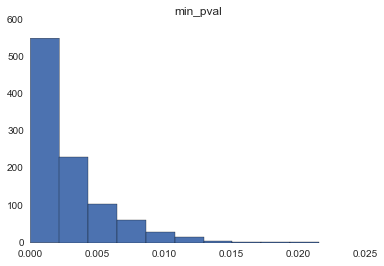

In [13]:
min_pvals.hist()

In [ ]:
%%R

library(qvalue)